In [6]:
import pandas as pd
import numpy as np
#from parameter_estimator import ParameterEstimator as pe
from robot import RobotDescription
import utils
from collections import deque
import cv2
import random
import math as m
from itertools import combinations
import pickle
from pytransform3d.transform_manager import *
import datetime

In [7]:
# functions to convert from and to spherical coordinates
def asSpherical(x, y, z):
    r = m.sqrt(x*x + y*y + z*z)
    theta = m.acos(z/r)*180 / m.pi  # to degrees
    phi = m.atan2(y, x)*180 / m.pi
    return r, theta, phi


def asCartesian(r, theta, phi):
    theta = theta * m.pi/180  # to radian
    phi = phi * m.pi/180
    x = r * m.sin(theta) * m.cos(phi)
    y = r * m.sin(theta) * m.sin(phi)
    z = r * m.cos(theta)
    return x, y, z

In [8]:
# generate the poses of markers
ids = list(range(30))  # marker ids to use
dict_T_WM = {}

for marker_id in ids:  # generate random poses for virtual markers
    r = np.random.normal(3, 0.12, 1)[0]
    theta = np.random.uniform(0, 90, 1)[0]
    phi   = np.random.uniform(0, 360, 1)[0]
    x, y, z = asCartesian(r, theta, phi)
    dict_T_WM[marker_id]= utils.H_rvec_tvec(np.array([0.0, 0, 0]), np.array([x, y, z]))


In [9]:
# generate robot configurations

# import trajectory
traj_file="/home/armin/catkin_ws/src/kident2/src/traj.csv"
try:
    df = pd.read_csv(traj_file)
except Exception as e:
    print(e)
traj = df.to_numpy()  # shape: (num_joints, num_traj_points)
traj = traj[:, 1:]  # delete header
traj = traj.T
print(len(traj))

120


In [10]:
# import robot values
theta_all = RobotDescription.dhparams["theta_nom"]
d_all = RobotDescription.dhparams["d_nom"]
r_all = RobotDescription.dhparams["r_nom"]
alpha_all = RobotDescription.dhparams["alpha_nom"]


In [11]:
def add_error_to_pose_measurement(pose_matrix, sigma_t, sigma_r):
    rvec, tvec = utils.mat2rvectvec(pose_matrix)
    rvec_n = np.array(rvec) + np.random.normal(0,sigma_r/1000,3)
    tvec_n = np.array(tvec) + np.random.normal(0,sigma_t/1000,3)
    return utils.H_rvec_tvec(rvec_n,tvec_n)

In [12]:
list_obs = []
list_cam_positions = []

add_error = False
error_factor_r = 1
error_factor_t = 1


# print out robot description
for item in RobotDescription.dhparams.keys():
    print(f"{item} : {RobotDescription.dhparams[item]}")
last_frame = RobotDescription.dhparams['num_cam_extrinsic'] + RobotDescription.dhparams['num_joints']
print(f"num frames total: {last_frame}")

# modify trajecory loaded from file
traj_long = traj[40:70]

# generate pseudo measurement data
for q in traj_long:
    
    # choose 4 random markers for this configuration
    markers = random.choices(ids, k=4)
    
    joint_tfs = RobotDescription.get_joint_tfs(q)
    
        
    tm = TransformManager()
    
    for tf in joint_tfs:
        from_frame, to_frame, A2B = tf['from_frame'], tf['to_frame'], tf['mat']
        tm.add_transform(from_frame, to_frame, A2B)
    
    
    list_cam_positions.append(np.array(tm.get_transform(str(last_frame), 'world'))[0:3,3])
    
    for marker in markers:
        
        T_WM = dict_T_WM[marker]
        tm.add_transform("marker", "world", T_WM)
        
        T_CM = tm.get_transform('marker', str(last_frame))
        
        if add_error:
            T_CM = add_error_to_pose_measurement(T_CM, error_factor_t, error_factor_r)
            
        obs = {"marker_id": None,
               "mat": None,
               "t": None,
               "q": q,
               "interp_dist": None}
        list_obs.append(obs)
    
        
df = pd.DataFrame(list_obs)

theta_nom : [0. 0. 0. 0. 0. 0. 0. 0.]
d_nom : [0.  0.  0.  0.  0.  0.  0.  0.1]
r_nom : [0.   0.   0.42 0.   0.4  0.   0.3  0.  ]
alpha_nom : [-1.57079633  1.57079633 -1.57079633 -1.57079633  1.57079633  1.57079633
 -1.57079633  1.        ]
num_joints : 7
num_cam_extrinsic : 1
num frames total: 8


In [13]:
observations_file_str = 'observations_untrained_poses' + '.p'
print(observations_file_str)
pd.to_pickle(df, observations_file_str)


observations_untrained_poses.p


----------------- FROM HERE ITS ONLY PLOTTING -------------------------

In [10]:
# import acin colors
from acin_colors import acin_colors

In [11]:
# collect xyz values of markers
marker_locations = np.array([dict_T_WM[marker][0:3,3] for marker in dict_T_WM.keys()])
#print(len(marker_locations[:,0]))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


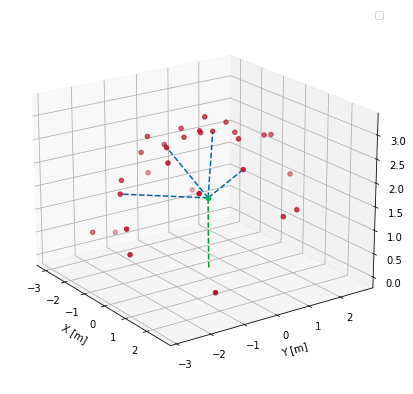

In [12]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.figure(figsize=(10,7)).add_subplot(projection='3d')


ax.scatter(marker_locations[:,0], marker_locations[:,1], marker_locations[:,2], c=acin_colors['red'])

list_cam_positions_np = np.array(list_cam_positions)
list_cam_positions_np = list_cam_positions_np[np.random.randint(low=0, high=30, size=1),:]
ax.scatter(list_cam_positions_np[:,0], list_cam_positions_np[:,1], list_cam_positions_np[:,2], c=acin_colors['green'])

lightgreen = tuple([c*0.8 for c in acin_colors['green']])
for pos in list_cam_positions_np:
    ax.plot3D([0,pos[0]],[0,pos[1]], [0,pos[2]], c=lightgreen, linestyle="--",)
    
pos = list_cam_positions_np[0]
i=1
ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)
i=5
ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)
i=3
ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)
i=2
ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)

# Make legend, set axes limits and labels
ax.legend()
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
#ax.set_zlim(0, 1)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35, roll=0)

#plt.show()
if False:
    plt.savefig('illustrate_groundtruth_data.pdf', format='pdf', bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


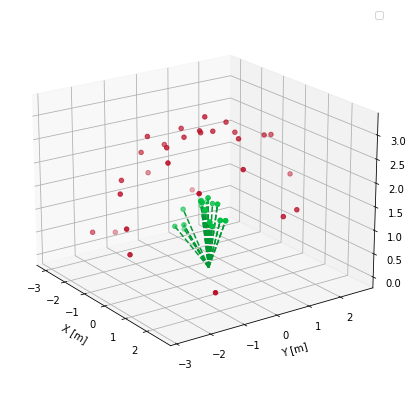

In [13]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.figure(figsize=(10,7)).add_subplot(projection='3d')


ax.scatter(marker_locations[:,0], marker_locations[:,1], marker_locations[:,2], c=acin_colors['red'])

list_cam_positions_np = np.array(list_cam_positions)
list_cam_positions_np = list_cam_positions_np[np.random.randint(low=0, high=30, size=30),:]
ax.scatter(list_cam_positions_np[:,0], list_cam_positions_np[:,1], list_cam_positions_np[:,2], c=acin_colors['green'])

lightgreen = tuple([c*0.8 for c in acin_colors['green']])
for pos in list_cam_positions_np:
    ax.plot3D([0,pos[0]],[0,pos[1]], [0,pos[2]], c=lightgreen, linestyle="--",)
    
#pos = list_cam_positions_np[0]
#i=1
#ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)
#i=5
#ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)
#i=3
#ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)
#i=2
#ax.plot3D([pos[0], marker_locations[i,0]],[pos[1], marker_locations[i,1]], [pos[2], marker_locations[i,2]], c=acin_colors['blue'], linestyle="--",)

# Make legend, set axes limits and labels
ax.legend()
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
#ax.set_zlim(0, 1)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35, roll=0)

#plt.show()
if False:
    plt.savefig('illustrate_groundtruth_data_2.pdf', format='pdf', bbox_inches='tight')